# Machine Learning with Titanic Dataset by Anna Shen

## Introduction
This is a Kaggle submission I made for a machine learning class at UC Davis. To learn more about this course, look up BAX 452 or Noah Gift on Github.

To start with, I created a Github repository for this submission that you can visit at https://github.com/annaeshen/ml_hw1_titanic.

## Dataset
The dataset is from this Kaggle (Titanic), at https://www.kaggle.com/c/titanic/data

### Data Dictionary
Variable / Definition / Key:
survival; Survival; 0 = No, 1 = Yes
pclass; Ticket class; 1 = 1st, 2 = 2nd, 3 = 3rd
sex; Sex
Age; Age in years
sibsp; # of siblings / spouses aboard the Titanic
parch; # of parents / children aboard the Titanic
ticket; Ticket number
fare; Passenger fare
cabin; Cabin number
embarked; Port of Embarkation; C = Cherbourg, Q = Queenstown, S = Southampton

## Dependencies
Importing the necessary packages:

In [36]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import RFECV

## Importing the Data using Pandas

In [37]:
train_df = pd.read_csv('train.csv', header=0)

## Exploratory Data Analysis
Now that we have the data loaded, we can check out what it looks like.

In [38]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Let's also remove any NAs from the Embarked column (there's only 2 of these).

In [39]:
train_df = train_df[train_df['Embarked'].notnull()]

### Age Distribution
Let's create a crosstab, or frequency chart, to determine the distribution of age. This helps me figure out the best model selection for the data.

In [40]:
pd.crosstab(index=train_df['Age'],columns="count")

col_0,count
Age,
0.42,1
0.67,1
0.75,2
0.83,2
0.92,1
1.00,7
2.00,10
3.00,6
4.00,10


Now we'll look at a histogram instead of the clunky table above using matplotlib.

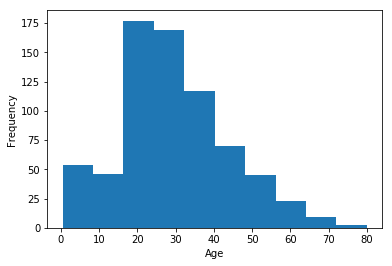

In [41]:
age = train_df[np.isfinite(train_df['Age'])]['Age']
plt.hist(age.values)
plt.xlabel('Age')
plt.ylabel('Frequency')

Given the output, Age looks to be gamma distributed. 

Now, in previewing the data I spotted an NaN. The machine learning model will not be happy with the NaNs so I need to get rid of them. My options are: 1) omit them, or 2) replace them. 

I'm trying to figure out if omitting these rows will be an issue. If a significant portion of the dataset has NaNs, perhaps simply removing the rows would not be the best idea because it could skew the dataset. Let's see how serious this missing data is by counting the number of rows with NaN in the Age column.

In [42]:
null_age = train_df['Age'].isnull().sum()
total_rows = train_df.shape[0]
ratio = null_age / total_rows
ratio

0.19910011248593926

Wow! If we omitted all the rows with NaNs in Age, we'd be ignoring 19.9% of the dataset! This is a significant amount to throw out. Instead, I'm going to do some imputation using the gamma distribution since that best resembles the Age data. I will call it something new for feature selection (later).

I'm setting a seed so that my work is reproducible.

In [43]:
seed = np.random.RandomState(514)
train_df['Age2'] = train_df['Age'].apply(lambda x: seed.gamma(train_df.Age.mean(),
                                                   train_df.Age.std())
                             if np.isnan(x) else x)
train_df['Age2'] = train_df['Age2'].astype(int)
train_df['Age2']

0       22
1       38
2       26
3       35
4       35
5      470
6       54
7        2
8       27
9       14
10       4
11      58
12      20
13      39
14      14
15      55
16       2
17     422
18      31
19     420
20      35
21      34
22      15
23      28
24       8
25      38
26     421
27      19
28     333
29     344
      ... 
861     21
862     48
863    461
864     24
865     42
866     27
867     31
868    576
869      4
870     26
871     47
872     33
873     47
874     28
875     15
876     20
877     19
878    441
879     56
880     25
881     33
882     22
883     28
884     25
885     39
886     27
887     19
888    473
889     26
890     32
Name: Age2, Length: 889, dtype: int64

## Machine Learning Setup
Now let's move to setting up my model. First I'll need to select my features, or variables.
### Preparation - Feature and Label Casting

Let's cast the data types as numbers and name them something new to differentiate them from the original dataset.

In [44]:
train_df['Sex2'] = train_df.Sex.map({'male': 1, 'female': 2})
train_df['Embarked2'] = train_df.Embarked.map({'C': 1, 'Q': 2, 'S':3})

Since a gamma distribution is right skewed, I'm going to normalize it by a log transformation. Log(0) is going to result in NaN though, so any young babies aged less than 1, I will replace with 1 before executing the log transformation.

In [45]:
train_df['Age2'] = train_df['Age2'].replace(0,1)
train_df['Age2'] = np.log(train_df['Age2'])
train_df['Age2']

0      3.091042
1      3.637586
2      3.258097
3      3.555348
4      3.555348
5      6.152733
6      3.988984
7      0.693147
8      3.295837
9      2.639057
10     1.386294
11     4.060443
12     2.995732
13     3.663562
14     2.639057
15     4.007333
16     0.693147
17     6.045005
18     3.433987
19     6.040255
20     3.555348
21     3.526361
22     2.708050
23     3.332205
24     2.079442
25     3.637586
26     6.042633
27     2.944439
28     5.808142
29     5.840642
         ...   
861    3.044522
862    3.871201
863    6.133398
864    3.178054
865    3.737670
866    3.295837
867    3.433987
868    6.356108
869    1.386294
870    3.258097
871    3.850148
872    3.496508
873    3.850148
874    3.332205
875    2.708050
876    2.995732
877    2.944439
878    6.089045
879    4.025352
880    3.218876
881    3.496508
882    3.091042
883    3.332205
884    3.218876
885    3.663562
886    3.295837
887    2.944439
888    6.159095
889    3.258097
890    3.465736
Name: Age2, Length: 889,

For feature selection, I'm throwing out the ticket_number and cabin_number since they are nearly unique identifiers and won't likely have a nonrandom impact on survival, as well as fare (assuming fare and passenger class are colinear)

In [46]:
# getting dependencies for feature importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# listing all possible features for processing (choosing final features later)
features = train_df[['Pclass','Sex2','SibSp','Parch','Age2','Embarked2']]

Let's define the label, or dependent variable/outcome that we're trying to predict, which is whether they survived.

In [47]:
label = train_df['Survived']

#### Preparation - Split the data into train and test
For feature selection I will be using the entire dataset.

I'll define the train and test split, and then fit on the training data.

In [48]:
# subsetting data into test and train
x_pretrain, x_pretest, y_pretrain, y_pretest = train_test_split(features,label,test_size=0,random_state=0)

# fitting the model
model = ExtraTreesClassifier(n_estimators=5)
model.fit(x_pretrain, y_pretrain)

# display the relative importance of each attribute
headers = x_pretrain.columns
values = list(zip(x_pretrain.columns, model.feature_importances_))
print(pd.DataFrame(values))

           0         1
0     Pclass  0.122825
1       Sex2  0.311910
2      SibSp  0.040091
3      Parch  0.063894
4       Age2  0.424558
5  Embarked2  0.036722


From the previous model, I'll select the features that came out to be most important as the features for input in my final model.

According to the output of the above, the feature importances are: 

Pclass 0.11 

Sex2 0.32 

SibSp 0.06 

Parch 0.05 

Age2 0.41 

Embarked2 0.04
 
I've decided to throw out Embarked2, SibSp, and Parch. Now I will proceed to build the model using these features.

In [49]:
final_features = train_df[['Pclass','Sex2','Age2']]

### Creating the Final ML Model
I'm going to use Random Forest because the number of categorical variables theoretically look like decision trees. I will proceed to build the model and now use an 85/15 split.

In [50]:
x_train, x_validation, y_train, y_validation = train_test_split(final_features,label,test_size=.15,random_state=0)

In [51]:
model = RandomForestClassifier()
rf_model = model.fit(x_train, y_train)

Getting my predictions...

In [52]:
predict_train = rf_model.predict(x_train)
predict_validation = rf_model.predict(x_validation)

Now I'll see how accurate the predictions are for the train and test data.

In [53]:
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train))
print('Validation Accuracy:', metrics.accuracy_score(y_validation, predict_validation))

Training Accuracy: 0.912582781457
Validation Accuracy: 0.731343283582


So I got an accuracy of 91% on the train (85%), and a 73% accuracy on the validation (15%). While this isn't super high, at least it implies that it's probably not overfit either.

## Analysis
Let's take a look at the feature importances of the final model.

For more on feature importance, I referred to http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [54]:
headers = x_train.columns
values = list(zip(x_train.columns, model.feature_importances_))
print(pd.DataFrame(values))

        0         1
0  Pclass  0.139910
1    Sex2  0.365732
2    Age2  0.494358


### Results:
The features with the highest importances are:
Age: 0.46
Sex: 0.39
Pclass: 0.14

This means that Age is the most important determining factor, followed by Sex, followed by Passenger class.

Let's also take a look at the confusion matrix to validate our findings. Note that a confusion matrix evaluates the accuracy of model (specifically instances of Type I and Type II error)

In [55]:
# source: http://scikit-learn.org/stable/modules/model_evaluation.html
print(metrics.confusion_matrix(y_validation, predict_validation))

[[63 17]
 [19 35]]


## Final Predictions
Now onto the final predictions of who survived in the Kaggle test dataset for export!

I'll need to redo any transformations onto the test.csv dataset.

In [35]:
# replacing the NaNs again
test_df = pd.read_csv('test.csv', header=0)

seed = np.random.RandomState(514)

# imputing ages again
test_df['Age2'] = test_df['Age'].apply(lambda x: seed.gamma(test_df.Age.mean(),
                                                   test_df.Age.std())
                             if np.isnan(x) else x)
test_df['Age2'] = test_df['Age2'].astype(int)

# normalizing Age with log transformation again
test_df['Age2'] = test_df['Age2'].replace(0,1)
test_df['Age2'] = np.log(test_df['Age2'])

# casting other features again
test_df['Sex2'] = test_df.Sex.map({'male': 1, 'female': 2})

In [66]:
# setting up ml again 
predict_test = rf_model.predict(test_df[['Pclass','Sex2','Age2']])

In [71]:
test_ids = test_df['PassengerId']
submission_df={
    'PassengerId':test_ids,
    'Survived':predict_test,
}
submission=pd.DataFrame(submission_df)
submission_file=submission.to_csv('AnnaShenTitanicSubmission2.csv', index=False)